In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import glob

import torch

import numpy as np
import pandas as pd

import json

from PIL import Image
from matplotlib import pyplot
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

In [2]:
from utils import get_score_from_embs, init_weights, log_likelihood

In [3]:
BATCH_SIZE = 64

EMB_DIMS = 768

INPUT_DIR = '../kcg-ml-image-pipeline/output/environmental/ranking_v1/'

VISION_WEIGHT_PATH = './weight/004/environmental/clip_vision.pt'
# VISION_WEIGHT_PATH = './weight/014/sa_0_4_vit_l_14_linear.pth'

TEXT_WEIGHT_PATH = './weight/004/environmental/clip_text.pt'

VISION_EMB_PATH = 'data/environmental/clip_vision_emb.npz'
TEXT_EMB_PATH = 'data/environmental/clip_text_emb.npz'

LR = 1e-3

In [4]:
vision_model = torch.nn.Linear(EMB_DIMS, 1, bias=True).cuda().eval()
vision_model.load_state_dict(torch.load(VISION_WEIGHT_PATH))

text_model = torch.nn.Linear(EMB_DIMS * 2, 1, bias=True).cuda().eval()
text_model.load_state_dict(torch.load(TEXT_WEIGHT_PATH))

<All keys matched successfully>

# load emb

In [5]:
npz = np.load(TEXT_EMB_PATH, allow_pickle=True)

text_file_paths = npz['file_paths']

text_positive_embs = npz['positive_pooler_outputs']
text_negative_embs = npz['negative_pooler_outputs']

text_path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(text_file_paths)}

In [6]:
npz = np.load(VISION_EMB_PATH, allow_pickle=True)

vision_file_paths = npz['file_paths']

vision_embs = npz['image_embeds']

vision_path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(vision_file_paths)}

In [7]:
file_paths = list(set(text_path_to_index.keys()) & set(vision_path_to_index.keys()))
path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(file_paths)}

In [8]:
indices = list(map(text_path_to_index.get, file_paths))

text_embs = np.concatenate([text_positive_embs[indices], text_negative_embs[indices]], axis=-1)

indices = list(map(vision_path_to_index.get, file_paths))

vision_embs = vision_embs[indices].astype('float32')

In [11]:
vision_scores = get_score_from_embs(vision_embs, vision_model, BATCH_SIZE)
text_scores = get_score_from_embs(text_embs, text_model, BATCH_SIZE)

# vision_scores = get_score_from_embs(vision_embs, vision_model, BATCH_SIZE, preprocess=lambda x: x / x.norm(dim=-1, keepdim=True))

  0%|          | 0/708 [00:00<?, ?it/s]

  0%|          | 0/708 [00:00<?, ?it/s]

In [12]:
#

In [13]:
train_indices, val_indices = train_test_split(np.arange(text_embs.shape[0]), test_size=0.2, random_state=42)
np.random.shuffle(train_indices)

In [14]:
train_x = torch.tensor(text_embs[train_indices]).half().cuda()
train_y = torch.tensor(vision_scores[train_indices]).half().cuda()
val_x = torch.tensor(text_embs[val_indices]).half().cuda()
val_y = torch.tensor(vision_scores[val_indices]).half().cuda()

In [15]:
#

In [77]:
model = torch.nn.Linear(train_x.shape[-1], 1).cuda()
# model = torch.nn.Sequential(
#     torch.nn.Linear(train_x.shape[-1], 64),
#     torch.nn.ReLU(),
#     torch.nn.Linear(64, 1)
# ).cuda()

init_weights(model)

In [78]:
LR = 1e-3
BATCH_SIZE = 1024
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [80]:
scaler = torch.cuda.amp.GradScaler()

mses, val_mses = list(), list()

for epoch in tqdm(range(1000)):
    
    model.train()
    
    for i in range(0, train_x.shape[0], BATCH_SIZE):

        with torch.cuda.amp.autocast(True):

            optimizer.zero_grad()

            y = model(train_x[i:i+BATCH_SIZE])

        # backward

        mse = torch.nn.functional.mse_loss(y, train_y[i:i+BATCH_SIZE, None])
        
        loss = mse

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
        mses.append(mse.detach().cpu().numpy())
        
    with torch.no_grad():
        with torch.cuda.amp.autocast(True):
            y = model(val_x)

            mse = torch.nn.functional.mse_loss(y, val_y[:, None])
    
            val_mses.append(mse.detach().cpu().numpy())
        
    if (epoch + 1) % 100 == 0:
        print(f'{np.mean(mses):.4f} {np.mean(val_mses):.4f}')
        mses, val_mses = list(), list()

  0%|          | 0/1000 [00:00<?, ?it/s]

2.6484 2.9677
2.6484 2.9738
2.6465 2.9747
2.6484 2.9748
2.6465 2.9748
2.6484 2.9748
2.6484 2.9748
2.6484 2.9748
2.6484 2.9748
2.6465 2.9748


In [82]:
with torch.no_grad():
    with torch.cuda.amp.autocast(True):
        
        x = torch.tensor(text_embs).half()
        
        pred_scores = model(x.cuda()).detach().cpu().numpy()
        
#         mu_sigma = model(x.cuda()).detach().cpu().numpy()
#         pred_scores = mu_sigma[..., 0]
#         pred_uncertainty = np.abs(mu_sigma[..., 1])

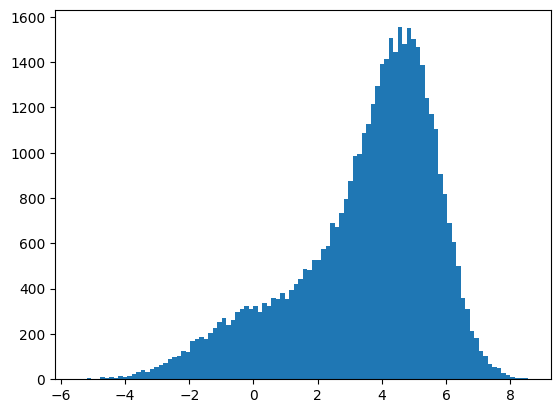

In [83]:
_ = pyplot.hist(pred_scores, bins=100)

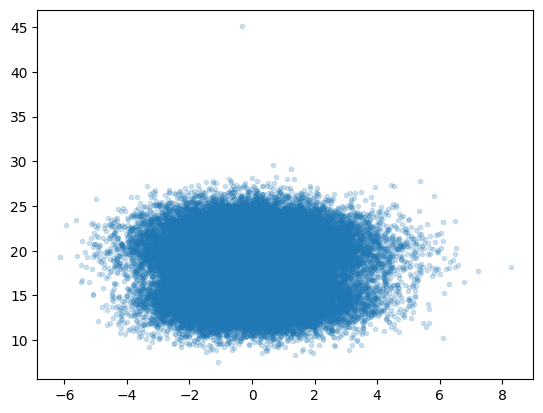

In [46]:
delta = pred_scores - vision_scores

pyplot.plot(delta, pred_uncertainty, '.', alpha=0.2)

4.9296126 1.8104204 18125
4.8279557 1.8312498 9025


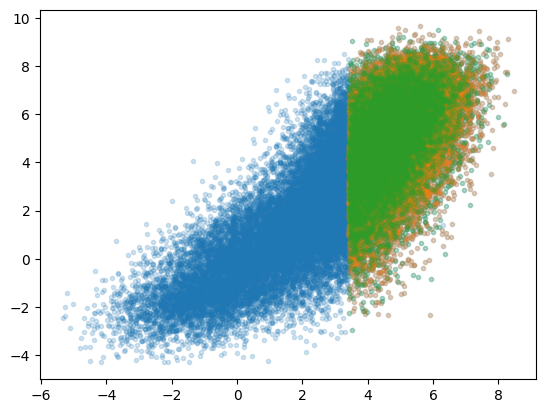

In [38]:
pyplot.plot(pred_scores, vision_scores, '.', alpha=0.2)

# mask = ((pred_scores - pred_uncertainty.mean()) > pred_scores.mean())
mask = (pred_scores > pred_scores.mean()) * (pred_uncertainty > pred_uncertainty.mean())
print(vision_scores[mask].mean(), vision_scores[mask].std(), mask.sum())
pyplot.plot(pred_scores[mask], vision_scores[mask], '.', alpha=0.2)

# mask = (pred_uncertainty < 1.5) * (vision_scores > 6)
# mask = ((pred_scores - pred_uncertainty) > pred_scores.mean())
mask = (pred_scores > pred_scores.mean()) * (pred_uncertainty < pred_uncertainty.mean())
print(vision_scores[mask].mean(), vision_scores[mask].std(), mask.sum())
pyplot.plot(pred_scores[mask], vision_scores[mask], '.', alpha=0.2)

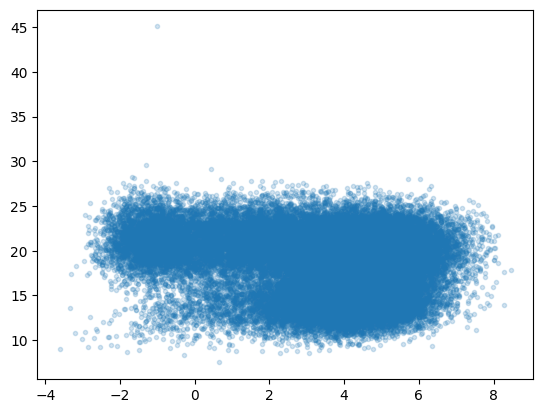

In [47]:
# pyplot.plot(text_scores, vision_scores, '.', alpha=0.2)
pyplot.plot(pred_scores, pred_uncertainty, '.', alpha=0.2)

# load rank data

In [11]:
paths = sorted(glob.glob(os.path.join(INPUT_DIR, 'ranking_data', '*.json')))

rank_pairs = list()
for path in tqdm(paths):
    js = json.load(open(path))
    
    file_path_1 = os.path.splitext(js['image_1_metadata']['file_path'])[0].replace('datasets/', '')
    file_path_2 = os.path.splitext(js['image_2_metadata']['file_path'])[0].replace('datasets/', '')
    
    if (file_path_1 not in path_to_index) or (file_path_2 not in path_to_index):
        continue
    rank_pairs.append((file_path_1, file_path_2, js['selected_image_index']))

  0%|          | 0/39552 [00:00<?, ?it/s]

In [12]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1', 'image_2', 'selected_image_index'])
ordered_pairs = [((image_1, image_2) if selected_image_index == 0 else (image_2, image_1)) for image_1, image_2, selected_image_index in rank_pairs.itertuples(index=False, name=None)]
ordered_pairs = pd.DataFrame(ordered_pairs, columns=['image_1', 'image_2'])

In [13]:
indices_1 = list(map(path_to_index.get, ordered_pairs['image_1']))
indices_2 = list(map(path_to_index.get, ordered_pairs['image_2']))

In [14]:
# y0, y1, delta = train_y0, train_y1, train_delta
y0, y1 = pred_scores[indices_1], pred_scores[indices_2]

_ = pyplot.hist(y0, bins=100, color='r', alpha=0.5)
_ = pyplot.hist(y1, bins=100, color='b', alpha=0.5)

NameError: name 'pred_scores' is not defined

In [41]:
# model = torch.nn.Linear(train_x.shape[-1], 2).cuda()
model = torch.nn.Sequential(
    torch.nn.Linear(train_x.shape[-1], 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
).cuda()

init_weights(model)

In [42]:
LR = 1e-3
BATCH_SIZE = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# optimizer = AGC(optimizer)

In [48]:
lls, sigmas, mses, val_mses = list(), list(), list(), list()

for epoch in tqdm(range(500)):
    
    model.train()
    
    for i in range(0, train_x.shape[0], BATCH_SIZE):

        optimizer.zero_grad()

        mu_sigma = model(train_x[i:i+BATCH_SIZE].float())
            
        # backward

        ll = log_likelihood(
            mu_sigma[..., 0], mu_sigma[..., 1] ** 2, 
            train_y[i:i+BATCH_SIZE], 
            # clip=10.
        )
        
        mse = torch.nn.functional.mse_loss(mu_sigma[..., 0], train_y[i:i+BATCH_SIZE].float())

        loss = ll + mse

        loss.backward()
        optimizer.step()
    
        lls.append(ll.detach().cpu().numpy())
        sigmas.append(torch.abs(mu_sigma[..., 1]).mean().detach().cpu().numpy())
        mses.append(mse.detach().cpu().numpy())
    
    with torch.no_grad():
        with torch.cuda.amp.autocast(True):
            
            mu_sigma = model(val_x)
            
            mse = torch.nn.functional.mse_loss(mu_sigma[..., 0], val_y)
    
            val_mses.append(mse.detach().cpu().numpy())
    
    if (epoch + 1) % 100 == 0:
        
        print(f'{np.mean(lls):.4f} {np.mean(sigmas):.4f} {np.mean(mses):.4f} {np.mean(val_mses):.4f}')
        lls, sigmas, mses, val_mses = list(), list(), list(), list()

  0%|          | 0/500 [00:00<?, ?it/s]

2.8044 16.8357 2.5491 2.8247
3.1804 29.6955 3.0455 3.1577
3.9242 51.8773 2.5948 2.9402
3.8755 49.4635 2.3968 2.9389
3.7050 42.0698 2.0871 3.1562


In [14]:
#

In [15]:
from sklearn.linear_model import LinearRegression

In [76]:
model = LinearRegression()

In [77]:
model.fit(text_embs[train_indices], vision_scores[train_indices])

LinearRegression()

In [78]:
pred_scores = model.predict(text_embs)

In [ ]:
#

In [1]:
import pandas as pd
import json

In [4]:
df = pd.DataFrame(json.load(open('./data/environmental/prompt.json')).values())

In [8]:
df['positive_prompt'] = df['positive_prompt'].str.lower()
df['negative_prompt'] = df['negative_prompt'].str.lower()
df.drop_duplicates(['positive_prompt', 'negative_prompt'], inplace=True)

In [14]:
df.to_csv('minio-2023-11-22.tsv.gz', index=False, sep='\t')